In [1]:
import torch,datetime,os
from collections import Counter
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体（显示中文）

from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error,mean_absolute_error

from importlib import reload
import utils_thuml_transformer,utils
reload(utils_thuml_transformer)
reload(utils)
from utils import seed_everything,get_data
from utils_thuml_transformer import time_features,TransformerModel,TimeSeriesDataSet
seed_everything(2023)
# https://github.com/thuml/Autoformer

In [2]:
info_map={
    'daily_min_temperatures.csv':{'freq':'d','seq_len':30,'lr':1e-4,'batch_size':16,'d_model':256,'n_heads':3,'e_layers':3,'d_layers':3,'d_ff':1024,'dropout':0.5,'scaler':'std'},
    'weather.csv':{'freq':'10min','seq_len':30,'lr':1e-4,'batch_size':32,'d_model':256,'n_heads':2,'e_layers':2,'d_layers':2,'d_ff':512,'dropout':0.5,'scaler':'std'},
    'exchange_rate.csv':{'freq':'d','seq_len':60,'lr':5e-6,'batch_size':16,'d_model':512,'n_heads':5,'e_layers':2,'d_layers':2,'d_ff':1024,'dropout':0.5,'scaler':'std'},
    'ETTh1.csv':{'freq':'h','seq_len':96,'lr':5e-5,'batch_size':32,'d_model':512,'n_heads':3,'e_layers':3,'d_layers':3,'d_ff':1024,'dropout':0.5,'scaler':'std'},
	'traffic.csv':{'freq':'h','seq_len':60,'lr':5e-5,'batch_size':32,'d_model':512,'n_heads':3,'e_layers':3,'d_layers':3,'d_ff':1024,'dropout':0.5,'scaler':'std'},
	'electricity.csv':{'freq':'h','seq_len':36,'lr':5e-5,'batch_size':32,'d_model':512,'n_heads':3,'e_layers':3,'d_layers':3,'d_ff':1024,'dropout':0.5,'scaler':'std'},
}
class CFG:
	device = 'cuda' if torch.cuda.is_available() else 'cpu'
	embed = 'timeF'
	activation = 'gelu'
	output_attention = False
	num_workers = 0
	train_epochs = 100
	early_stop_num = 5
	model_name = './data/thuml_transformer.pth'
	label_len = 0
	pred_len = 1
	enc_in = 1 # features num
	dec_in = 1 # features num
	c_out = 1
	path = 'electricity.csv'
	label = 'Temp' if path == 'daily_min_temperatures.csv' else 'OT'
	date_col = 'Date' if path == 'daily_min_temperatures.csv' else 'date'
	scaler = info_map[path]['scaler']

	freq = info_map[path]['freq']
	seq_len = info_map[path]['seq_len']
	d_model = info_map[path]['d_model']
	n_heads = info_map[path]['n_heads']
	e_layers = info_map[path]['e_layers']
	d_layers = info_map[path]['d_layers']
	d_ff = info_map[path]['d_ff']
	dropout = info_map[path]['dropout']
	batch_size = info_map[path]['batch_size']
	lr = info_map[path]['lr']

args=CFG()

In [3]:
data,train,valid,test = get_data(args.path)

In [4]:
train_data = TimeSeriesDataSet(args, data, len(valid), len(test), scaler=args.scaler)
vali_data = TimeSeriesDataSet(args, data, len(valid), len(test), scaler=args.scaler,is_valid=True)
test_data = TimeSeriesDataSet(args, data, len(valid), len(test), scaler=args.scaler,is_test=True)
all_data = TimeSeriesDataSet(args, data, len(valid), len(test), scaler=args.scaler,is_all=True)

train_loader = DataLoader(train_data,batch_size=args.batch_size,shuffle=False,num_workers=args.num_workers,drop_last=False)
vali_loader = DataLoader(vali_data,batch_size=args.batch_size,shuffle=False,num_workers=args.num_workers,drop_last=False)
test_loader = DataLoader(test_data,batch_size=args.batch_size,shuffle=False,num_workers=args.num_workers,drop_last=False)
all_loader = DataLoader(all_data,batch_size=args.batch_size,shuffle=False,num_workers=args.num_workers,drop_last=False)

In [5]:
def vali(args, model, vali_loader, criterion, epoch):
	total_loss = []
	model.eval()
	pbar = tqdm(enumerate(vali_loader,start=1))
	with torch.no_grad():
		for idx, (batch_x, batch_y, batch_x_mark, batch_y_mark) in pbar:
			batch_x = batch_x.float().to(args.device)
			batch_y = batch_y.float().to(args.device)

			batch_x_mark = batch_x_mark.float().to(args.device)
			batch_y_mark = batch_y_mark.float().to(args.device)

			# decoder input
			dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
			dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(args.device)
			# encoder - decoder
			if args.output_attention:
				outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
			else:
				outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

			outputs = outputs[:, -args.pred_len:, 0:]
			batch_y = batch_y[:, -args.pred_len:, 0:]

			pred = outputs.detach().cpu()
			true = batch_y.detach().cpu()

			loss = criterion(pred, true)
			total_loss.append(loss)

			pbar.set_description(f'\t[Valid] Iter: {idx}/{len(vali_loader)} loss: {loss:.10f}')

	total_loss = np.average(total_loss)
	model.train()
	return total_loss

def train_model(args, model, train_dataloader, valid_dataloader=None):
	model_optim = torch.optim.Adam(model.parameters(), lr=args.lr)
	criterion = nn.MSELoss(reduction='mean').to(args.device)
	train_loss = []
	valid_loss = []
	best_loss = np.inf
	num = 0

	for epoch in range(args.train_epochs):
		epoch += 1
		train_epoch_loss = []
		model.train()
		pbar = tqdm(enumerate(train_dataloader,start=1))
		for idx,(batch_x, batch_y, batch_x_mark, batch_y_mark) in pbar:
			batch_x = batch_x.float().to(args.device)

			batch_y = batch_y.float().to(args.device)
			batch_x_mark = batch_x_mark.float().to(args.device)
			batch_y_mark = batch_y_mark.float().to(args.device)

			# decoder input
			dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
			dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(args.device)

			# encoder - decoder
			if args.output_attention:
				outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
			else:
				outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

			outputs = outputs[:, -args.pred_len:, :]
			batch_y = batch_y[:, -args.pred_len:, :]
			loss = criterion(outputs, batch_y)
			train_epoch_loss.append(loss.item())

			loss.backward()
			model_optim.step()
			model_optim.zero_grad()

			pbar.set_description(f'\t[Train] Iter: {idx}/{len(train_dataloader)} loss: {loss.item():.10f}')

		train_epoch_loss = np.average(train_epoch_loss)
		train_loss.append(train_epoch_loss)

		if valid_dataloader is not None:
			valid_epoch_loss = vali(args, model, vali_loader, criterion, epoch)
			valid_loss.append(valid_epoch_loss)
			if valid_epoch_loss < best_loss:
				best_loss = valid_epoch_loss
				num = 0
				suffix='*'
				torch.save({'epoch': epoch, 'loss': best_loss, 'model_state_dict': model.state_dict()}, args.model_name)
			else:
				num += 1
				suffix=f' [{num}/{args.early_stop_num}]'

			print(f'Epoch: {epoch}/{args.train_epochs}\ttrain loss: {train_epoch_loss:.10f}\tvalid loss: {valid_epoch_loss:.10f}\tbest loss: {best_loss:.10f}{suffix}')
		else:
			print(f'Epoch: {epoch}/{args.train_epochs}\ttrain loss: {train_epoch_loss:.10f}')

		if args.early_stop_num == num:
			print('early stop...')
			break

		print('-'*111)

	return train_loss,valid_loss

model = TransformerModel(args).float().to(args.device)
train_hist, valid_hist = train_model(args, model, train_loader, vali_loader)

	[Train] Iter: 812/812 loss: 0.0524961576: : 812it [01:13, 11.01it/s]
	[Valid] Iter: 5/5 loss: 0.0422589630: : 5it [00:00, 46.20it/s]


Epoch: 1/100	train loss: 0.3613662033	valid loss: 0.1057003513	best loss: 0.1057003513*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0750477165: : 812it [01:12, 11.13it/s]
	[Valid] Iter: 5/5 loss: 0.0332313776: : 5it [00:00, 46.85it/s]


Epoch: 2/100	train loss: 0.1661833049	valid loss: 0.0810967460	best loss: 0.0810967460*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0133668417: : 812it [01:13, 11.08it/s]
	[Valid] Iter: 5/5 loss: 0.0377261974: : 5it [00:00, 45.99it/s]


Epoch: 3/100	train loss: 0.1356298363	valid loss: 0.0704751760	best loss: 0.0704751760*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0067721093: : 812it [01:13, 11.06it/s]
	[Valid] Iter: 5/5 loss: 0.0500936322: : 5it [00:00, 46.53it/s]


Epoch: 4/100	train loss: 0.1179082438	valid loss: 0.0703973100	best loss: 0.0703973100*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0454446189: : 812it [01:13, 11.03it/s]
	[Valid] Iter: 5/5 loss: 0.0522816367: : 5it [00:00, 31.10it/s]


Epoch: 5/100	train loss: 0.1146659811	valid loss: 0.0695473999	best loss: 0.0695473999*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0434402414: : 812it [01:13, 11.07it/s]
	[Valid] Iter: 5/5 loss: 0.0455787852: : 5it [00:00, 39.99it/s]


Epoch: 6/100	train loss: 0.1057324353	valid loss: 0.0577110872	best loss: 0.0577110872*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0339751020: : 812it [01:13, 10.99it/s]
	[Valid] Iter: 5/5 loss: 0.0391296074: : 5it [00:00, 43.78it/s]


Epoch: 7/100	train loss: 0.1007205094	valid loss: 0.0553443357	best loss: 0.0553443357*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0314949453: : 812it [01:13, 10.98it/s]
	[Valid] Iter: 5/5 loss: 0.0424721278: : 5it [00:00, 45.58it/s]


Epoch: 8/100	train loss: 0.0988623081	valid loss: 0.0560987070	best loss: 0.0553443357 [1/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0118841939: : 812it [01:13, 11.04it/s]
	[Valid] Iter: 5/5 loss: 0.0428662822: : 5it [00:00, 44.76it/s]


Epoch: 9/100	train loss: 0.0925658402	valid loss: 0.0649566278	best loss: 0.0553443357 [2/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0123729436: : 812it [01:13, 11.06it/s]
	[Valid] Iter: 5/5 loss: 0.0398172587: : 5it [00:00, 31.06it/s]


Epoch: 10/100	train loss: 0.0936762113	valid loss: 0.0637730807	best loss: 0.0553443357 [3/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0119694173: : 812it [01:13, 10.98it/s]
	[Valid] Iter: 5/5 loss: 0.0383916274: : 5it [00:00, 46.54it/s]


Epoch: 11/100	train loss: 0.0894047577	valid loss: 0.0539288446	best loss: 0.0539288446*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0113037881: : 812it [01:13, 11.05it/s]
	[Valid] Iter: 5/5 loss: 0.0466944240: : 5it [00:00, 47.26it/s]


Epoch: 12/100	train loss: 0.0899563428	valid loss: 0.0612724535	best loss: 0.0539288446 [1/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0240861103: : 812it [01:13, 11.00it/s]
	[Valid] Iter: 5/5 loss: 0.0443755277: : 5it [00:00, 47.30it/s]


Epoch: 13/100	train loss: 0.0872008271	valid loss: 0.0593944974	best loss: 0.0539288446 [2/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0306603536: : 812it [01:13, 11.07it/s]
	[Valid] Iter: 5/5 loss: 0.0396588296: : 5it [00:00, 46.06it/s]


Epoch: 14/100	train loss: 0.0857993035	valid loss: 0.0609970689	best loss: 0.0539288446 [3/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0203662030: : 812it [01:13, 11.00it/s]
	[Valid] Iter: 5/5 loss: 0.0438973904: : 5it [00:00, 30.01it/s]


Epoch: 15/100	train loss: 0.0869668723	valid loss: 0.0541774258	best loss: 0.0539288446 [4/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0343321823: : 812it [01:13, 11.05it/s]
	[Valid] Iter: 5/5 loss: 0.0322710425: : 5it [00:00, 28.01it/s]


Epoch: 16/100	train loss: 0.0843648049	valid loss: 0.0500791892	best loss: 0.0500791892*
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0124821560: : 812it [01:13, 10.99it/s]
	[Valid] Iter: 5/5 loss: 0.0314526930: : 5it [00:00, 43.98it/s]


Epoch: 17/100	train loss: 0.0826698701	valid loss: 0.0527677909	best loss: 0.0500791892 [1/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0276084244: : 812it [01:13, 10.98it/s]
	[Valid] Iter: 5/5 loss: 0.0411127210: : 5it [00:00, 46.42it/s]


Epoch: 18/100	train loss: 0.0812689870	valid loss: 0.0647921562	best loss: 0.0500791892 [2/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0109048160: : 812it [01:13, 11.05it/s]
	[Valid] Iter: 5/5 loss: 0.0318812840: : 5it [00:00, 27.91it/s]


Epoch: 19/100	train loss: 0.0796726508	valid loss: 0.0532372370	best loss: 0.0500791892 [3/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0125270151: : 812it [01:13, 11.03it/s]
	[Valid] Iter: 5/5 loss: 0.0350247175: : 5it [00:00, 34.30it/s]


Epoch: 20/100	train loss: 0.0831399754	valid loss: 0.0571984537	best loss: 0.0500791892 [4/5]
---------------------------------------------------------------------------------------------------------------


	[Train] Iter: 812/812 loss: 0.0173515268: : 812it [01:13, 10.99it/s]
	[Valid] Iter: 5/5 loss: 0.0427525491: : 5it [00:00, 45.58it/s]

Epoch: 21/100	train loss: 0.0819335384	valid loss: 0.0676531196	best loss: 0.0500791892 [5/5]
early stop...


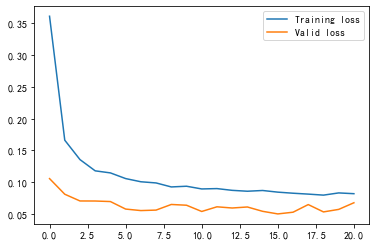

In [6]:
plt.plot(train_hist, label="Training loss")
plt.plot(valid_hist, label="Valid loss")
plt.legend()

In [7]:
checkpoints=torch.load(args.model_name,map_location=args.device)
model.load_state_dict(checkpoints['model_state_dict'])
model.eval()

def get_pred(data_loader):
    with torch.no_grad():
        preds_test = []
        trues_test = []
        for batch_x, batch_y, batch_x_mark, batch_y_mark in data_loader:
            batch_x = batch_x.float().to(args.device)

            batch_y = batch_y.float().to(args.device)
            batch_x_mark = batch_x_mark.float().to(args.device)
            batch_y_mark = batch_y_mark.float().to(args.device)

            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(args.device)

            # encoder - decoder
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

            outputs = outputs[:, -args.pred_len:, :]
            batch_y = batch_y[:, -args.pred_len:, :].to(args.device)

            outputs = outputs.detach().cpu().numpy()
            batch_y = batch_y.detach().cpu().numpy()

            preds_test.append(outputs)
            trues_test.append(batch_y)
        preds_test=np.concatenate(preds_test, axis=0)
        trues_test=np.concatenate(trues_test, axis=0)

        preds_test=data_loader.dataset.inverse_transform(preds_test.squeeze(-1)).reshape(preds_test.shape[0],preds_test.shape[1],1)
        prediction=preds_test.flatten()
    return prediction

true_cases = test.values
predicted_cases,add_counter = get_pred(test_loader)

true_cases_valid = valid.values
predicted_cases_valid,add_counter_valid = get_pred(vali_loader)

true_cases_all = data.values[-len(all_data):]
predicted_cases_all,add_counter_all = get_pred(all_loader)

print(f'all: mse={mean_squared_error(true_cases_all,predicted_cases_all)} mae={mean_absolute_error(true_cases_all,predicted_cases_all)}')
print(f'valid: mse={mean_squared_error(true_cases_valid,predicted_cases_valid)} mae={mean_absolute_error(true_cases_valid,predicted_cases_valid)}')
print(f'test: mse={mean_squared_error(true_cases,predicted_cases)} mae={mean_absolute_error(true_cases,predicted_cases)}')

# electricity
# all: mse=28426.424655032777 mae=119.20798756047513
# valid: mse=15953.585218307046 mae=87.93702189127605
# test: mse=13350.980947286718 mae=91.32396104600694

# traffic
# all: mse=0.0001268280138375729 mae=0.009164147479631499
# valid: mse=0.00011910082662579494 mae=0.008369530969878865
# test: mse=8.561620886194762e-05 mae=0.008043238212235156

# ETTh1
# all: mse=8.94909151496585 mae=1.8668308351214733
# valid: mse=0.47324015691926036 mae=0.4169032805495792
# test: mse=0.6323783184077709 mae=0.5838025742106967

# exchange_rate
# all: mse=0.0002892876515722395 mae=0.012415360302338292
# valid: mse=6.34356648103262e-05 mae=0.0060859614836169884
# test: mse=4.5442846395612935e-05 mae=0.004890393746439614

# weather
# all: mse=19.166042992911766 mae=2.8987098573880403
# valid: mse=1.9316112653592898 mae=0.9936478932698576
# test: mse=2.477035790501269 mae=1.0905159844292551

# daily_min_temperatures
# all: mse=5.828854147944343 mae=1.9098987558018363
# valid: mse=5.237968544799083 mae=1.7916155497233073
# test: mse=3.852115935158198 mae=1.4951607981035784

all: mse=28426.424655032777 mae=119.20798756047513
valid: mse=15953.585218307046 mae=87.93702189127605
test: mse=13350.980947286718 mae=91.32396104600694


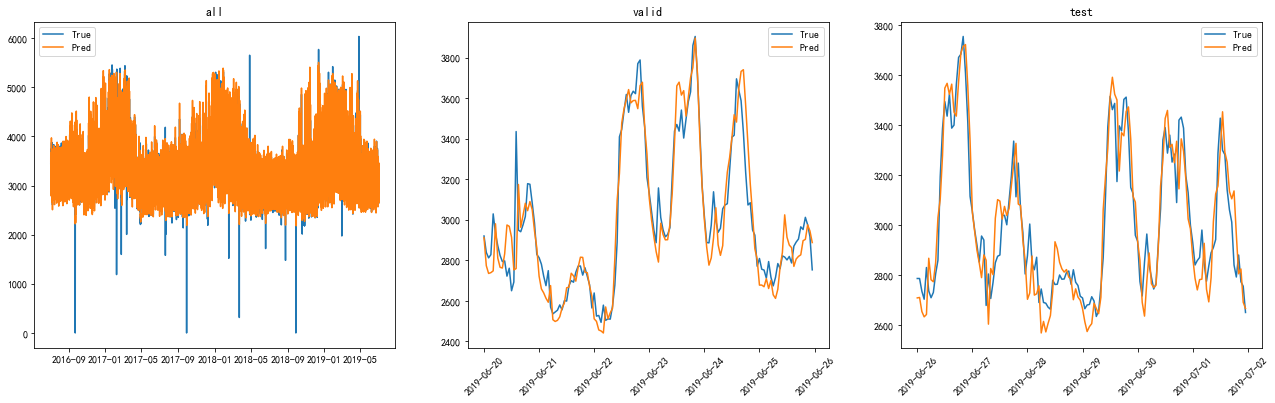

In [8]:
fig,ax=plt.subplots(1,3,figsize=(22,6))
ax[0].plot(data.index[-len(all_data):],true_cases_all,label='True')
ax[0].plot(data.index[-len(all_data):],predicted_cases_all,label='Pred')
ax[0].set_title('all')
ax[0].legend()
ax[1].plot(valid.index,true_cases_valid,label='True')
ax[1].plot(valid.index,predicted_cases_valid,label='Pred')
ax[1].set_title('valid')
ax[1].legend()
ax[1].tick_params(axis='x', labelrotation=45)
ax[2].plot(test.index,true_cases,label='True')
ax[2].plot(test.index,predicted_cases,label='Pred')
ax[2].set_title('test')
ax[2].legend()
ax[2].tick_params(axis='x', labelrotation=45)
plt.show()

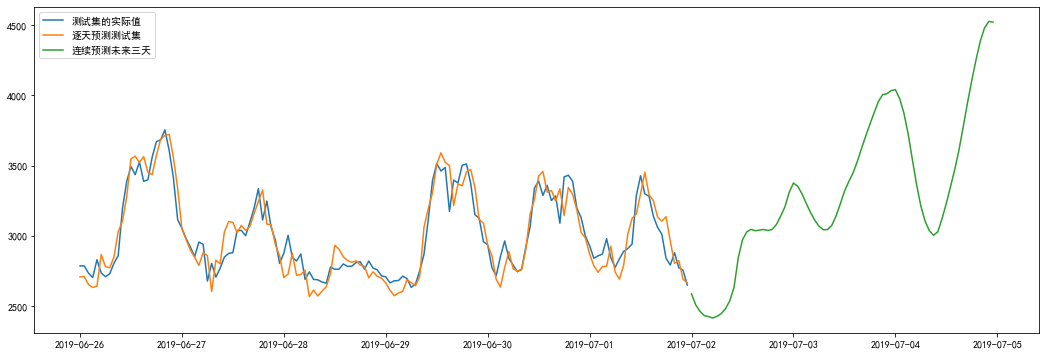

In [9]:
# 根据验证集按天迭代预测测试集
DAYS_TO_PREDICT = len(test)
model.eval()
with torch.no_grad():
    test_seq = torch.from_numpy(all_data.data[-(args.seq_len+len(test)):-len(test)]).view(1, args.seq_len, 1).float()
    test_y = test_seq[:,-args.label_len:,:] if args.label_len > 0 else torch.tensor(0).view(1,1,1).float()
    test_seq_stamp = data.index[-(args.seq_len+len(test)):-len(test)].values.tolist()
    test_seq_mark = torch.from_numpy(time_features(pd.to_datetime(test_seq_stamp),freq=args.freq).transpose(1, 0)).float().to(args.device)
    if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
        test_y_stamp = [(data.index[-(args.seq_len+len(test)):-len(test)][-1] + datetime.timedelta(hours=i+1)).to_numpy().tolist() for i in range(test_y.shape[1])]
    elif args.path == 'weather.csv':
        test_y_stamp = [(data.index[-(args.seq_len+len(test)):-len(test)][-1] + datetime.timedelta(minutes=(i+1)*10)).to_numpy().tolist() for i in range(test_y.shape[1])]
    elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
        test_y_stamp = [(data.index[-(args.seq_len+len(test)):-len(test)][-1] + datetime.timedelta(days=i+1)).to_numpy().tolist() for i in range(test_y.shape[1])]
    test_y_mark = torch.from_numpy(time_features(pd.to_datetime(test_y_stamp),freq=args.freq).transpose(1, 0)).float().to(args.device)

    dec_inp = torch.zeros([test_y.shape[0], args.pred_len, test_y.shape[2]]).float()
    dec_inp = torch.cat([test_y[:, :args.label_len, :], dec_inp], dim=1).float().to(args.device)

    preds = []
    for i in range(DAYS_TO_PREDICT):
        outputs = model(test_seq.to(args.device), test_seq_mark.unsqueeze(0), dec_inp, test_y_mark.unsqueeze(0))
        pred = outputs.item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten().tolist()
        new_seq.append(all_data.scaler.transform(np.array([test.iloc[i]]).reshape(-1, 1)).item())
        new_seq = new_seq[1:]
        
        test_seq = torch.from_numpy(np.array(new_seq)).view(1, args.seq_len, 1).float()
        test_y = test_seq[:,-args.label_len:,:] if args.label_len > 0 else torch.tensor(0).view(1,1,1).float()
        test_seq_stamp += test_y_stamp
        test_seq_stamp = test_seq_stamp[1:]
        test_seq_mark = torch.from_numpy(time_features(pd.to_datetime(test_seq_stamp),freq=args.freq).transpose(1, 0)).float().to(args.device)
        if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
            test_y_stamp += [(pd.to_datetime(test_y_stamp[-1]) + datetime.timedelta(hours=1)).to_numpy().tolist()]
        elif args.path == 'weather.csv':
            test_y_stamp += [(pd.to_datetime(test_y_stamp[-1]) + datetime.timedelta(minutes=10)).to_numpy().tolist()]
        elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
            test_y_stamp += [(pd.to_datetime(test_y_stamp[-1]) + datetime.timedelta(days=1)).to_numpy().tolist()]
        test_y_stamp = test_y_stamp[1:]
        test_y_mark = torch.from_numpy(time_features(pd.to_datetime(test_y_stamp),freq=args.freq).transpose(1, 0)).float().to(args.device)

        dec_inp = torch.zeros([test_y.shape[0], args.pred_len, test_y.shape[2]]).float()
        dec_inp = torch.cat([test_y[:, :args.label_len, :], dec_inp], dim=1).float().to(args.device)


preds = all_data.inverse_transform(np.expand_dims(preds, axis=0)).flatten()
forcast_df1=pd.Series(preds,name=args.label)
if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
    forcast_df1.index=pd.date_range(start=valid.index.max()+datetime.timedelta(hours=1),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path == 'weather.csv':
    forcast_df1.index=pd.date_range(start=valid.index.max()+datetime.timedelta(minutes=10),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
    forcast_df1.index=pd.date_range(start=valid.index.max()+datetime.timedelta(days=1),periods=DAYS_TO_PREDICT)
forcast_df1.index.name=args.date_col

# 根据测试集按天迭代预测接下来的时间
if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
    DAYS_TO_PREDICT = 3 * 24
    label='连续预测未来三天'
elif args.path == 'weather.csv':
    DAYS_TO_PREDICT = 1 * 6 * 24
    label='连续预测未来一天'
elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
    DAYS_TO_PREDICT = 31
    label='连续预测未来一个月'
model.eval()
with torch.no_grad():
    test_seq = torch.from_numpy(all_data.data[-args.seq_len:]).view(1, args.seq_len, 1).float()
    test_y = test_seq[:,-args.label_len:,:] if args.label_len > 0 else torch.tensor(0).view(1,1,1).float()
    test_seq_stamp = data.index[-args.seq_len:].values.tolist()
    test_seq_mark = torch.from_numpy(time_features(pd.to_datetime(test_seq_stamp),freq=args.freq).transpose(1, 0)).float().to(args.device)
    if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
        test_y_stamp = [(data.index[-args.seq_len:][-1] + datetime.timedelta(hours=i+1)).to_numpy().tolist() for i in range(test_y.shape[1])]
    elif args.path == 'weather.csv':
        test_y_stamp = [(data.index[-args.seq_len:][-1] + datetime.timedelta(minutes=(i+1)*10)).to_numpy().tolist() for i in range(test_y.shape[1])]
    elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
        test_y_stamp = [(data.index[-args.seq_len:][-1] + datetime.timedelta(days=i+1)).to_numpy().tolist() for i in range(test_y.shape[1])]
    test_y_mark = torch.from_numpy(time_features(pd.to_datetime(test_y_stamp),freq=args.freq).transpose(1, 0)).float().to(args.device)

    dec_inp = torch.zeros([test_y.shape[0], args.pred_len, test_y.shape[2]]).float()
    dec_inp = torch.cat([test_y[:, :args.label_len, :], dec_inp], dim=1).float().to(args.device)

    preds = []
    for _ in range(DAYS_TO_PREDICT):
        outputs = model(test_seq.to(args.device), test_seq_mark.unsqueeze(0), dec_inp, test_y_mark.unsqueeze(0))
        pred = outputs.item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten().tolist()
        new_seq.append(pred)
        new_seq = new_seq[1:]

        test_seq = torch.from_numpy(np.array(new_seq)).view(1, args.seq_len, 1).float()
        test_y = test_seq[:,-args.label_len:,:] if args.label_len > 0 else torch.tensor(0).view(1,1,1).float()
        test_seq_stamp += test_y_stamp
        test_seq_stamp = test_seq_stamp[1:]
        test_seq_mark = torch.from_numpy(time_features(pd.to_datetime(test_seq_stamp),freq=args.freq).transpose(1, 0)).float().to(args.device)
        if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
            test_y_stamp += [(pd.to_datetime(test_y_stamp[-1]) + datetime.timedelta(hours=1)).to_numpy().tolist()]
        elif args.path == 'weather.csv':
            test_y_stamp += [(pd.to_datetime(test_y_stamp[-1]) + datetime.timedelta(minutes=10)).to_numpy().tolist()]
        elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
            test_y_stamp += [(pd.to_datetime(test_y_stamp[-1]) + datetime.timedelta(days=1)).to_numpy().tolist()]
        test_y_stamp = test_y_stamp[1:]
        test_y_mark = torch.from_numpy(time_features(pd.to_datetime(test_y_stamp),freq=args.freq).transpose(1, 0)).float().to(args.device)

        dec_inp = torch.zeros([test_y.shape[0], args.pred_len, test_y.shape[2]]).float()
        dec_inp = torch.cat([test_y[:, :args.label_len, :], dec_inp], dim=1).float().to(args.device)

preds = all_data.inverse_transform(np.expand_dims(preds, axis=0)).flatten()
forcast_df2=pd.Series(preds,name=args.label)
if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
    forcast_df2.index=pd.date_range(start=data.index.max()+datetime.timedelta(hours=1),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path == 'weather.csv':
    forcast_df2.index=pd.date_range(start=data.index.max()+datetime.timedelta(minutes=10),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
    forcast_df2.index=pd.date_range(start=data.index.max()+datetime.timedelta(days=1),periods=DAYS_TO_PREDICT)
forcast_df2.index.name=args.date_col

fig,ax=plt.subplots(1,1,figsize=(18,6))
ax.plot(test.index,test.values,label='测试集的实际值')
ax.plot(test.index,forcast_df1.values,label='逐天预测测试集')
ax.plot(forcast_df2.index,forcast_df2.values,label=label)
ax.legend()
plt.show()